In [1]:
import polars as pl
import polars.selectors as cs
import re


In [2]:
def extract_id(s) -> int:
    # Extract VAC from string
    match = re.search(r'(\d+)', s)

    if match is None:
        raise ValueError(f"Could not match ID from {s}")
    else:
        return int(match.group(1)) 

In [12]:
demog = pl.read_excel(
    "/projectnb/vkolagrp/bellitti/clinicalnotes-databasing-validated/data/LLM study spreadsheet_Extended_2025.06.23.xlsx",
    infer_schema_length=None,
)

In [16]:
demog.select(cs.contains('PET'))

aPET 0. No 1. Yes,# of visits until PET ordered,PET result 1.Normal 2.Abnormal
i64,f64,str
0,null,null
0,null,null
0,null,null
0,null,null
0,null,null
…,…,…
1,1.0,"""2"""
1,1.0,"""1"""
1,1.0,"""2"""


In [27]:
demog.filter(
    (pl.col('aPET 0. No 1. Yes') == 0) &
    (pl.col('PET result 1.Normal 2.Abnormal') == '1')
)

VAC,Data collection by,"# Appts: 1,2,3,4,5,6, NA (duplicate)",Age At Consult,Year of Birth,sex,Educ Yrs,Race 1.Caucasian 2. Africanamerican 3. Asian 4.other,ethnicity 0.non hispanic 1.hispanic,occupation 1. working 2. retired 3. unemployed,Marital status 1. Single never married 2. married 3. divorced/widowed,living situation 1. Alone 2. Family 3. CRC 4. ALF 5. NH 6. inpatient,aPET 0. No 1. Yes,Date Performed,# of visits until PET ordered,PET result 1.Normal 2.Abnormal,1st Appt Date,MOCA,t-MOCA,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs,"Behavioral disturbance 0. No 1. Yes (anger, irritability, disinhibition)",Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia,NBSE Date,Second visit date,MoCA,t-MOCA_1,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs _1,Behavioral disturbance 0.No 1.Yes,Cognitive syndrome 2nd 1.Unimpaired 2.SCD 3. MCI 4. Dementia,Medication Change 0.No 1.Yes,Living situation change 0.No 1.Yes,DC'd 0.no 1.yes,3rd Visit,MOCA Total,t-MOCA_2,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs _2,Behavioral disturbance 0.No 1.Yes,Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_1,Med Change 0.No 1.Yes,Living situation change 0.No 1.Yes_1,DC'd 0.no 1.yes_1,Fourth fu date,MOCA Total_1,t-MoCA,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs _3,Behavioral disturbance 0.No 1.Yes_1,Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_2,Med Change 0.No 1.Yes_1,Living situation change 0.No 1.Yes_2,Discharged0.no 1.yes,Fifth fu date,MOCA Total_2,t-MoCA_1,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs _4,Behavioral disturbance 0.No 1.Yes_2,Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_3,Medication Change 0.No 1.Yes_1,Living situation change 0.No 1.Yes_3,Discharged0.no 1.yes_1,Sixth fu date,MOCA_1,t-MOCA_3,Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4. dep any bADLs 5. dependent all bADLs _5,Behavioral disturbance 0.No 1.Yes_3,Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_4,Med Change 0.No 1.Yes_2,Living Situation Changed 0. No 1. Yes,Discharged0.no 1.yes_2
str,str,str,str,i64,str,str,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,i64,i64,str,str,str,i64,f64,i64,i64,i64,i64,i64,i64,str,str,f64,i64,i64,i64,i64,i64,i64,str,f64,f64,i64,i64,i64,i64,i64,i64,str,f64,f64,str,i64,i64,i64,i64,i64,date,f64,str,i64,i64,i64,i64,i64,i64
"""2171""",null,null,null,1930,"""M""",null,1,0,null,null,null,0,"""2024-12-11 00:00:00""",null,"""1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [22]:
demog.filter(pl.col('aPET 0. No 1. Yes') == 0).select(
    pl.col('PET result 1.Normal 2.Abnormal').value_counts()
)

PET result 1.Normal 2.Abnormal
struct[2]
"{""1"",1}"
"{"" "",56}"
"{null,1503}"


In [ ]:

# The VAC column is inconsistent, needs to be converted to int
demog = demog.with_columns(
    pl.col("VAC").map_elements(extract_id, return_dtype=pl.Int64).alias("VAC"),
    pl.col('# Appts: 1,2,3,4,5,6, NA (duplicate)').str.extract(r'\b(\d+)\b'),
    pl.col('Educ Yrs').str.extract(r'\b(\d+)\b'), # sometimes it's ranges, this rounds down
    pl.col('sex').str.strip_chars(' ').str.to_uppercase(),
    pl.when(
        pl.col('PET result 1.Normal 2.Abnormal').is_in(['1','2'])
    ).then(
        pl.col('PET result 1.Normal 2.Abnormal')
    ).otherwise(None).cast(pl.Int64) # clean up pet results, there are a couple of unexplained sentinel values
).filter(
    pl.col("VAC") != 1448  # almost no data on this patient
).with_columns(
    pl.col('Age At Consult').cast(pl.Int64),
    pl.col('# Appts: 1,2,3,4,5,6, NA (duplicate)').cast(pl.Int64),
    pl.col('Educ Yrs').cast(pl.Int64),
)

In [62]:
demog.select(
    pl.col('sex').value_counts()
)

sex
struct[2]
"{""F"",79}"
"{""TGF"",1}"
"{null,173}"
"{""M"",1869}"


In [7]:
# nbse = pl.read_parquet('/projectnb/vkolagrp/bellitti/clinicalnotes-databasing-validated/notebooks/NBSE_tabulated.parquet')

In the NBSE file the list of medications is still a list, we can convert that to unique identifiers using RxNorm

In [8]:
# data = nbse.join(demog,on='VAC',how="left").drop('cerad_rapid_forgetting_words')

The PET result column has a few notes and sentinel values not explained. We will keep only values equal to 1 or 2, anything else is treated as null. 
We will also assume that the PET does not change, 

In [ ]:
apet = demog.filter(pl.col('PET result 1.Normal 2.Abnormal').str.strip_chars().is_in(['1','2'])).select(
    pl.col('VAC'),
    pl.col('age'),
    pl.col('sex').replace(['male','female'],['M','F']), # needs to be checked,
    pl.col('sex').replace(['male','female'],[1,0]).cast(pl.Int64).alias('sex_m'), # needs to be checked,
    # pl.col('sex_right').replace(['M','F'],['male','female']), # needs to be checked
    pl.col('education'),
    pl.col('is_telephone_encounter'),
    pl.col('moca_total_score'),
    pl.col('mmse_total_score'),
    pl.col('gds_total_score'),
    pl.col('gai_total_score'),
    pl.col('lubben_total_score'),
    pl.col('ucla_loneliness_total_score'),
    pl.col('letter_fluency_total'),
    pl.col('category_fluency_total'),
    # pl.col('cerad_rapid_forgetting'),
    cs.contains('cerad'),
    pl.col('PET result 1.Normal 2.Abnormal').alias('apet').replace(['1','2'],['normal','abnormal'])
)

ColumnNotFoundError: unable to find column "completed"; valid columns: ["VAC", "Data collection by", "# Appts: 1,2,3,4,5,6, NA (duplicate)", "Age At Consult", "Year of Birth", "sex", "Educ Yrs", "Race 1.Caucasian 2. Africanamerican 3. Asian 4.other", "ethnicity 0.non hispanic 1.hispanic", "occupation 1. working 2. retired 3. unemployed", "Marital status 1. Single never married 2. married 3. divorced/widowed", "living situation 1. Alone 2. Family 3. CRC 4. ALF 5. NH 6. inpatient", "aPET 0. No 1. Yes", "Date Performed", "# of visits until PET ordered", "PET result 1.Normal 2.Abnormal", "1st Appt Date", "MOCA", "t-MOCA", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs ", "Behavioral disturbance 0. No 1. Yes (anger, irritability, disinhibition)", "Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia", "NBSE Date", "Second visit date", "MoCA", "t-MOCA_1", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs _1", "Behavioral disturbance 0.No 1.Yes", "Cognitive syndrome 2nd 1.Unimpaired 2.SCD 3. MCI 4. Dementia", "Medication Change 0.No 1.Yes", "Living situation change 0.No 1.Yes", "DC'd 0.no 1.yes", "3rd Visit", "MOCA Total", "t-MOCA_2", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs _2", "Behavioral disturbance  0.No 1.Yes", "Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_1", "Med Change 0.No 1.Yes", "Living situation change 0.No 1.Yes_1", "DC'd 0.no 1.yes_1", "Fourth fu date", "MOCA Total_1", "t-MoCA", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs _3", "Behavioral disturbance  0.No 1.Yes_1", "Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_2", "Med Change 0.No 1.Yes_1", "Living situation change 0.No 1.Yes_2", "Discharged0.no 1.yes", "Fifth fu date", "MOCA Total_2", "t-MoCA_1", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs _4", "Behavioral disturbance  0.No 1.Yes_2", "Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_3", "Medication Change 0.No 1.Yes_1", "Living situation change 0.No 1.Yes_3", "Discharged0.no 1.yes_1", "Sixth fu date", "MOCA_1", "t-MOCA_3", "Function 1.independent 2. dep any iADLs 3. dependent all iADLs 4.  dep any bADLs 5. dependent all bADLs _5", "Behavioral disturbance  0.No 1.Yes_3", "Cognitive syndrome 1st 1.Unimpaired 2.SCD 3. MCI 4. Dementia_4", "Med Change 0.No 1.Yes_2", "Living Situation Changed 0. No 1. Yes", "Discharged0.no 1.yes_2"]

In [8]:
apet.head(1)

filename,VAC,completed,age,sex,sex_m,education,is_telephone_encounter,moca_total_score,mmse_total_score,gds_total_score,gai_total_score,lubben_total_score,ucla_loneliness_total_score,letter_fluency_total,category_fluency_total,cerad_encoding_trials,cerad_encoding_total,cerad_delayed_recall,cerad_recognition_hits,cerad_false_positives,cerad_corrected_recognition_total,cerad_rapid_forgetting,cerad_notes,cerad_rapid_forgetting_words_cabin,cerad_rapid_forgetting_words_pole,cerad_rapid_forgetting_words_queen,cerad_rapid_forgetting_words_ticket,cerad_rapid_forgetting_words_engine,cerad_rapid_forgetting_words_grass,cerad_rapid_forgetting_words_arm,cerad_rapid_forgetting_words_shore,cerad_rapid_forgetting_words_letter,cerad_rapid_forgetting_words_butter,apet
str,i64,date,i64,str,i64,i64,bool,i64,i64,i64,i64,i64,i64,i64,i64,list[i64],i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""VAC1018_JND_DA.aeb-no changees…",1018,2020-11-06,60,"""M""",1,14,true,23,null,10,12,null,null,26,32,"[3, 4, 4]",11,4,7,0,7,1,"""Note that these results are to…",null,null,1,null,null,null,null,null,null,null,"""normal"""


In [9]:
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

def logistic_regression_metrics_with_coefs(df: pl.DataFrame, predictor_cols: list, target_col: str, random_state: int = 42):
    """
    Fit a logistic regression on a Polars DataFrame with 5-fold CV, computing metrics and coefficients
    with error bars.

    Returns a dictionary with:
    - metrics: dict of mean and std for accuracy, recall, precision, recall_neg, precision_neg
    - coefficients: dict with raw coefficients and odds ratios (mean ± std) for each predictor
    """
    # Convert to NumPy arrays
    X = df.select(predictor_cols).to_numpy()
    y = df[target_col].to_numpy()

    model = LogisticRegression(max_iter=1000, random_state=random_state)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Metrics storage
    metrics_storage = { "Accuracy": [], "Sensitivity": [], "PPV": [], "Specificity": [], "NPV": [] }
    coef_storage = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metrics_storage["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics_storage["Sensitivity"].append(recall_score(y_test, y_pred,pos_label='abnormal'))
        metrics_storage["Specificity"].append(recall_score(y_test, y_pred, pos_label='normal'))
        metrics_storage["PPV"].append(precision_score(y_test, y_pred,pos_label='abnormal'))
        metrics_storage["NPV"].append(precision_score(y_test, y_pred, pos_label='normal'))

        coef_storage.append(model.coef_[0])  # shape: (n_features,)

    coef_storage = np.array(coef_storage)  # shape: (n_folds, n_features)

    coef_dict = {}
    for i, col in enumerate(predictor_cols):
        raw_coef = coef_storage[:, i]
        odds_ratio = np.exp(raw_coef)
        coef_dict[col] = {
            "raw_coef_mean": raw_coef.mean(),
            "raw_coef_std": raw_coef.std(),
            "odds_ratio_mean": odds_ratio.mean(),
            "odds_ratio_std": odds_ratio.std()
        }

    # Aggregate metrics
    metrics_dict = {k: {"mean": np.mean(v), "std": np.std(v)} for k, v in metrics_storage.items()}

    return {"metrics": metrics_dict, "coefficients": coef_dict}


def results_to_polars_df(results):
    """
    Convert logistic regression results dictionary to Polars DataFrames:
    - metrics_df: metrics with mean and std
    - coefficients_df: coefficients with raw and odds ratio stats
    Returns a dictionary of Polars DataFrames.
    """
    metrics_data = []
    for metric, stats in results['metrics'].items():
        metrics_data.append({
            "metric": metric,
            "mean": stats['mean'],
            "std": stats['std']
        })
    metrics_df = pl.DataFrame(metrics_data)

    coef_data = []
    for feature, stats in results['coefficients'].items():
        coef_data.append({
            "feature": feature,
            "raw_coef_mean": stats['raw_coef_mean'],
            "raw_coef_std": stats['raw_coef_std'],
            "odds_ratio_mean": stats['odds_ratio_mean'],
            "odds_ratio_std": stats['odds_ratio_std']
        })
    coefficients_df = pl.DataFrame(coef_data)

    return {"metrics_df": metrics_df, "coefficients_df": coefficients_df}


In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

def plot_logistic_results_clean(results):
    """
    Plot metrics and coefficients side by side using ggplot style and narrow bars.
    """

    metrics = results['metrics']
    coefs = results['coefficients']

    fig, axes = plt.subplots(1, 2, figsize=(5,4))

    metric_names = list(metrics.keys())
    means = [metrics[m]['mean'] for m in metric_names]
    stds = [metrics[m]['std'] for m in metric_names]

    axes[0].errorbar(metric_names, means, yerr=stds, marker='.', capsize=5,ls='none')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Cross-validated Metrics',size=10)
    # axes[0].set_ylim(0, 1)
    axes[0].set_xticks(axes[0].get_xticks(),metric_names,rotation='vertical')

    feature_names = list(coefs.keys())
    odds_mean = [coefs[f]['odds_ratio_mean'] for f in feature_names]
    odds_std = [coefs[f]['odds_ratio_std'] for f in feature_names]

    axes[1].errorbar(feature_names, odds_mean, yerr=odds_std, marker='.', capsize=5, ls='none')
    axes[1].set_ylabel('Odds Ratio')
    axes[1].set_title('Odds Ratios',size=10)
    axes[1].axhline(1, color='gray', linestyle='--')  # reference line for OR=1
    axes[1].set_xticks(axes[1].get_xticks(),feature_names,rotation='vertical')

    plt.tight_layout()
    plt.show()


In [11]:
apet.head(1)

filename,VAC,completed,age,sex,sex_m,education,is_telephone_encounter,moca_total_score,mmse_total_score,gds_total_score,gai_total_score,lubben_total_score,ucla_loneliness_total_score,letter_fluency_total,category_fluency_total,cerad_encoding_trials,cerad_encoding_total,cerad_delayed_recall,cerad_recognition_hits,cerad_false_positives,cerad_corrected_recognition_total,cerad_rapid_forgetting,cerad_notes,cerad_rapid_forgetting_words_cabin,cerad_rapid_forgetting_words_pole,cerad_rapid_forgetting_words_queen,cerad_rapid_forgetting_words_ticket,cerad_rapid_forgetting_words_engine,cerad_rapid_forgetting_words_grass,cerad_rapid_forgetting_words_arm,cerad_rapid_forgetting_words_shore,cerad_rapid_forgetting_words_letter,cerad_rapid_forgetting_words_butter,apet
str,i64,date,i64,str,i64,i64,bool,i64,i64,i64,i64,i64,i64,i64,i64,list[i64],i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""VAC1018_JND_DA.aeb-no changees…",1018,2020-11-06,60,"""M""",1,14,true,23,null,10,12,null,null,26,32,"[3, 4, 4]",11,4,7,0,7,1,"""Note that these results are to…",null,null,1,null,null,null,null,null,null,null,"""normal"""


statistic,age,sex_m,education,moca_total_score,apet
str,f64,f64,f64,f64,str
"""count""",272.000,272.000,272.000,272.000,"""272"""
"""null_count""",0.000,0.000,0.000,0.000,"""0"""
"""mean""",72.272,0.952,14.088,20.125,null
"""std""",6.411,0.214,2.624,4.115,null
"""min""",49.000,0.000,4.000,2.000,"""abnormal"""
"""50%""",73.000,1.000,14.000,20.000,null
"""max""",89.000,1.000,25.000,30.000,"""normal"""


metric,mean,std
str,f64,f64
"""Accuracy""",0.596,0.028
"""Sensitivity""",0.722,0.083
"""PPV""",0.607,0.023
"""Specificity""",0.448,0.089
"""NPV""",0.582,0.050


feature,raw_coef_mean,raw_coef_std,odds_ratio_mean,odds_ratio_std
str,f64,f64,f64,f64
"""age""",-0.073,0.005,0.930,0.005
"""sex_m""",0.303,0.188,1.376,0.228
"""education""",-0.072,0.033,0.931,0.031
"""moca_total_score""",0.066,0.021,1.068,0.023


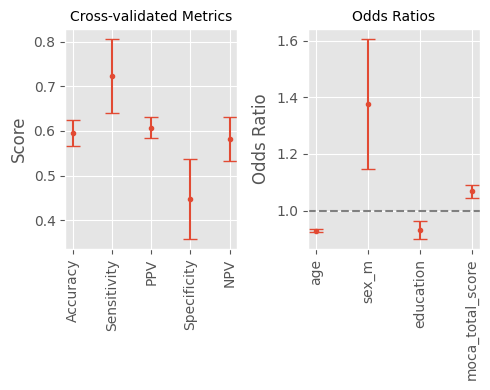

In [12]:
_df = apet.select("age", "sex_m", "education", "moca_total_score", "apet").drop_nulls()

results = logistic_regression_metrics_with_coefs(
    _df,
    predictor_cols=["age", "sex_m", "education", "moca_total_score"],
    target_col="apet",
)

dfs = results_to_polars_df(results)

with pl.Config(set_float_precision=3):
    display(_df.describe(percentiles=0.5))
    display(dfs["metrics_df"])
    display(dfs["coefficients_df"])

plot_logistic_results_clean(results)

statistic,age,sex_m,education,cerad_rapid_forgetting,apet
str,f64,f64,f64,f64,str
"""count""",406.0,406.0,406.0,406.0,"""406"""
"""null_count""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",71.7,1.0,14.0,1.2,null
"""std""",6.5,0.2,2.6,1.4,null
"""min""",41.0,0.0,4.0,0.0,"""abnormal"""
"""50%""",72.0,1.0,14.0,1.0,null
"""max""",89.0,1.0,25.0,8.0,"""normal"""


statistic,age,sex_m,education,cerad_rapid_forgetting,apet
str,f64,f64,f64,f64,str
"""count""",406.000,406.000,406.000,406.000,"""406"""
"""null_count""",0.000,0.000,0.000,0.000,"""0"""
"""mean""",71.736,0.961,14.002,1.197,null
"""std""",6.490,0.195,2.562,1.392,null
"""min""",41.000,0.000,4.000,0.000,"""abnormal"""
"""50%""",72.000,1.000,14.000,1.000,null
"""max""",89.000,1.000,25.000,8.000,"""normal"""


metric,mean,std
str,f64,f64
"""Accuracy""",0.611,0.056
"""Sensitivity""",0.610,0.102
"""PPV""",0.603,0.052
"""Specificity""",0.611,0.070
"""NPV""",0.622,0.066


feature,raw_coef_mean,raw_coef_std,odds_ratio_mean,odds_ratio_std
str,f64,f64,f64,f64
"""age""",-0.079,0.010,0.924,0.009
"""sex_m""",0.118,0.221,1.152,0.241
"""education""",-0.059,0.009,0.943,0.008
"""cerad_rapid_forgetting""",0.029,0.041,1.030,0.044


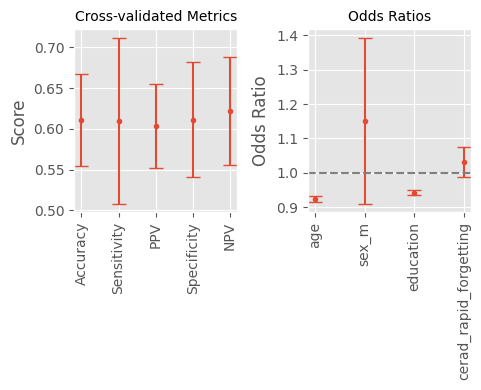

In [13]:
_df = apet.select("age", "sex_m", "education", "cerad_rapid_forgetting", "apet").drop_nulls()

with pl.Config(set_float_precision=1):
    display(_df.describe(percentiles=0.5))

results = logistic_regression_metrics_with_coefs(
    _df,
    predictor_cols=["age", "sex_m", "education", "cerad_rapid_forgetting"],
    target_col="apet",
)

dfs = results_to_polars_df(results)

with pl.Config(set_float_precision=3):
    display(_df.describe(percentiles=0.5))
    display(dfs["metrics_df"])
    display(dfs["coefficients_df"])


plot_logistic_results_clean(results)

In [14]:
rf_words = apet.select(cs.contains('word'))

statistic,age,sex_m,education,cerad_rapid_forgetting,apet,rf_total_instances
str,f64,f64,f64,f64,str,f64
"""count""",406.0,406.0,406.0,406.0,"""406""",406.0
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""",71.7,1.0,14.0,1.2,null,1.4
"""std""",6.5,0.2,2.6,1.4,null,2.3
"""min""",41.0,0.0,4.0,0.0,"""abnormal""",0.0
"""50%""",72.0,1.0,14.0,1.0,null,0.0
"""max""",89.0,1.0,25.0,8.0,"""normal""",14.0


statistic,age,sex_m,education,cerad_rapid_forgetting,apet,rf_total_instances
str,f64,f64,f64,f64,str,f64
"""count""",406.000,406.000,406.000,406.000,"""406""",406.000
"""null_count""",0.000,0.000,0.000,0.000,"""0""",0.000
"""mean""",71.736,0.961,14.002,1.197,null,1.355
"""std""",6.490,0.195,2.562,1.392,null,2.306
"""min""",41.000,0.000,4.000,0.000,"""abnormal""",0.000
"""50%""",72.000,1.000,14.000,1.000,null,0.000
"""max""",89.000,1.000,25.000,8.000,"""normal""",14.000


metric,mean,std
str,f64,f64
"""Accuracy""",0.608,0.051
"""Sensitivity""",0.590,0.072
"""PPV""",0.609,0.060
"""Specificity""",0.626,0.094
"""NPV""",0.611,0.048


feature,raw_coef_mean,raw_coef_std,odds_ratio_mean,odds_ratio_std
str,f64,f64,f64,f64
"""age""",-0.080,0.009,0.923,0.009
"""sex_m""",0.093,0.237,1.128,0.254
"""education""",-0.058,0.009,0.943,0.008
"""rf_total_instances""",-0.033,0.040,0.969,0.040


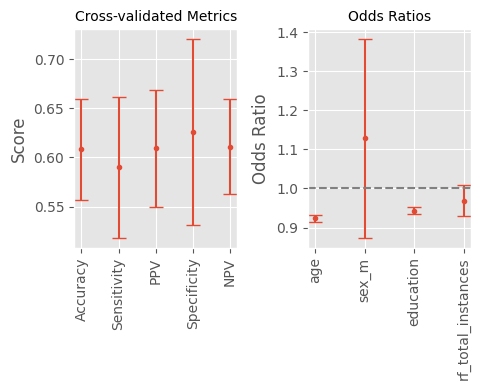

In [15]:
word_cols = apet.select(cs.contains("word")).columns

_df = apet.select(
    "age",
    "sex_m",
    "education",
    "cerad_rapid_forgetting",
    "apet",
    pl.sum_horizontal(word_cols).alias("rf_total_instances"),
).drop_nulls()

with pl.Config(set_float_precision=1):
    display(_df.describe(percentiles=0.5))

results = logistic_regression_metrics_with_coefs(
    _df,
    predictor_cols=["age", "sex_m", "education", 'rf_total_instances'],
    target_col="apet",
)

dfs = results_to_polars_df(results)

with pl.Config(set_float_precision=3):
    display(_df.describe(percentiles=0.5))
    display(dfs["metrics_df"])
    display(dfs["coefficients_df"])


plot_logistic_results_clean(results)

In [19]:
apet.select(pl.col('apet').value_counts())

apet
struct[2]
"{""abnormal"",228}"
"{""normal"",247}"
